# Cifar 10 Classification Problem

## 1. Problem Definition

This is one of most known problems in the image classification and object recognition field nowadays.

## 2. Data

The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.
This data is from the official website of Toronto University : https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

## 3. Evaluation

Our Evaluation metrics is going to be the `Accuracy` ! So simple isn't it ? 

## 4. Features

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [ ]:
import tensorflow as tf
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import pathlib
import os 
from six.moves import cPickle as pickle
import IPython
from google.colab import drive
from sklearn import metrics
!pip install -U keras-tuner
import kerastuner as kt

In [ ]:
drive.mount('/content/drive')

### Download the data

In [ ]:
if tf.config.list_physical_devices("GPU"):
  BATCH_SIZE=128
elif tf.config.list_physical_devices("XLA_CPU") :
  BATCH_SIZE=1024
else :
  BATCH_SIZE=32
BUFFER_SIZE=10000
INPUT_SHAPE=(None,32,32,3)
OUTPUT_SHAPE=10

In [ ]:
#data_dir = tf.keras.utils.get_file("cifar-10","https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz",untar=True,cache_subdir=pathlib.Path().absolute())
data_dir=pathlib.Path("/content/drive/My Drive/Cifar 10 /Data/cifar-10")

### Get the Data Ready 

In [ ]:
def unpickle(filepath):
    """
    Gets the filename of pickle type file and extracts the data from it
    args:
    * filepath : str or path to pickle filename 
    """
    fo = open(filepath,'rb')
    dict=pickle.load(fo,encoding="latin1")
    X=dict["data"]
    X=X.reshape(10000,3,32,32).transpose(0,2,3,1)
    X=X.astype("float32")/255.0
    y=dict["labels"]
    y=np.array(y)
    y=tf.keras.utils.to_categorical(y)
    fo.close
    return X,y

In [ ]:
def data(data_dir):
    """
    Gets the Whole dataset from the directory containing the pickle files
    args:
    * data_dir: str or path to directory containing dataset
    """
    images_test,labels_test= unpickle(data_dir/"test_batch")
    images_train_1,labels_train_1=unpickle(data_dir/"data_batch_1")
    images_train_2,labels_train_2=unpickle(data_dir/"data_batch_2")
    images_train_3,labels_train_3=unpickle(data_dir/"data_batch_3")
    images_train_4,labels_train_4=unpickle(data_dir/"data_batch_4")
    images_train_5,labels_train_5=unpickle(data_dir/"data_batch_5")
    images_train=np.concatenate((images_train_1,images_train_2,images_train_3,images_train_4,images_train_5))
    labels_train=np.concatenate((labels_train_1,labels_train_2,labels_train_3,labels_train_4,labels_train_5)) 
    return (images_train,labels_train),(images_test,labels_test)

In [ ]:
def augmentation(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.4)
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) 
    image = tf.image.random_crop(image, size=[32,32,3])
    return image, label

In [ ]:
(train_images,train_labels),(test_images,test_labels)=data(data_dir)

In [ ]:
def batchify(images,labels,data_augmentation=False):
    """
    Takes our Data and makes a pipeline to increase the performance 
    of our model 
    args:
    * images: array-containing containing the images arrays
    * labels: array-like containing the labels
    * data_augmentation: Boolean whether to perform data_augmentation or not 
    """
    print("Batchifying the data")
    if tf.config.list_physical_devices("GPU"):
      policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
      tf.keras.mixed_precision.experimental.set_policy(policy)
    ds=tf.data.Dataset.from_tensor_slices((tf.constant(images,dtype=tf.float32),tf.constant(labels)))
    ds=ds.shuffle(BUFFER_SIZE)
    if data_augmentation:
      ds=ds.map(augmentation,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds=ds.batch(BATCH_SIZE,drop_remainder=True)
    ds=ds.cache()
    ds=ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return ds

In [ ]:
train_dataset = batchify(train_images,train_labels)
validation_dataset= batchify(test_images,test_labels)
train_aug_dataset=batchify(train_images,train_labels,data_augmentation=True)

Batchifying the data
Batchifying the data


### Visualize the Data 

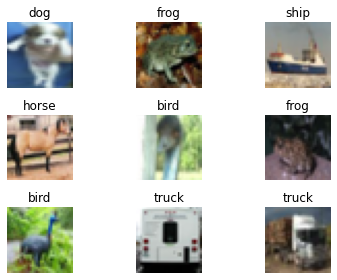

In [ ]:
class_names=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for image, label in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,1+i)
        plt.imshow(image[i].numpy())
        plt.title(class_names[label[i].numpy().argmax()])
        plt.axis(False)
    plt.tight_layout()
    plt.show()

### Build Our Model 

In this section we are going to:
* Build a custom model (VGG-like Architecture)
* Hand-Tune the custom model
* use Keras-Tuner to get better performance

In [ ]:
def build_model(filters,layers_feat,layers_dense,dropout,dropout_rate,regularizer,weight_decay,batch_normalization):
  """
  Builds a Keras sequential model for image classification with a VGG like architecture
  args:
  * filters: number of filters for image feature extraction this number doubles after every pooling layer
  * layers_feat: int, number of feature extraction layers
  * layers_dense: int, number of dense layers
  * dropout: boolean, whether to include dropout layers or not
  * dropout_rate: float, if dropout is set to True this indicates the dropout probability of the layer
  * regularizer: boolean, whether to include l2 kernel regularizers or not
  * weight_decay: float, if regularizer is set to True this indicates the penality rate of the L2 regularizer 
  """
  model = tf.keras.models.Sequential()
  for i in range(layers_feat):
      model.add(tf.keras.layers.Conv2D(filters=(1+i)*filters,kernel_size=3,padding="same",activation="relu",kernel_initializer='he_uniform'))
      model.add(tf.keras.layers.Conv2D(filters=(1+i)*filters,kernel_size=3,padding="same",activation="relu",kernel_initializer='he_uniform'))
      if batch_normalization:
        model.add(tf.keras.layers.BatchNormalization())
      model.add(tf.keras.layers.MaxPooling2D((2,2)))
      if dropout:
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
  model.add(tf.keras.layers.Flatten())
  if (layers_dense>1):
    units=1024
    for i in range (1,layers_dense):
      if regularizer:
        model.add(tf.keras.layers.Dense(units=units,activation="relu",kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
      else:
        model.add(tf.keras.layers.Dense(units=units,activation="relu",kernel_initializer='he_uniform'))
      if dropout:
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
      units=units/2
  if regularizer:
    model.add(tf.keras.layers.Dense(units=128,activation="relu",kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
  else:
    model.add(tf.keras.layers.Dense(units=128,activation="relu",kernel_initializer='he_uniform'))
  if dropout:
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
  if regularizer:
    model.add(tf.keras.layers.Dense(units=OUTPUT_SHAPE,dtype=tf.float32,activation="softmax",kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))  
  else:
    model.add(tf.keras.layers.Dense(units=OUTPUT_SHAPE,dtype=tf.float32,activation="softmax"))
  model.build(INPUT_SHAPE)
  model.compile(optimizer=tf.keras.optimizers.Adam(),experimental_steps_per_execution=1024,loss=tf.keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])
  model.summary()
  return (model)

In [ ]:
%load_ext tensorboard
def get_callbacks(log_dir,name):
  """ returns callbacks : early stopping, tensorboard and model checkpoint
  args:
  log_dir: str, path to Logs directory
  name: str, model name
  """
  return([tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=20),tf.keras.callbacks.ModelCheckpoint("/content/drive/My Drive/Cifar 10 /Best Models/"+name+".h5",monitor="val_accuracy",save_best_only=True,save_freq="epoch")])

In [ ]:
def fit_model(name,train_dataset,validation_dataset,filters=32,layers_feat=3,layers_dense=1,dropout=False,dropout_rate=.2,regularizer=False,weight_decay=1e-3,batch_normalization=False,epochs=20,initial_epoch=0,callbacks=True):
    """
  Builds, fits the model to the dataset and finally returns it
  args:
  * name: str, name of the model 
  * filters: int, number of filters for image feature extraction this number doubles after every pooling layer
  * layers_feat: int, number of feature extraction layers
  * layers_dense: int, number of dense layers
  * dropout: boolean, whether to include dropout layers or not
  * dropout_rate: float, if dropout is set to True this indicates the dropout probability of the layer
  * regularizer: boolean, whether to include l2 kernel regularizers or not
  * weight_decay: float, if regularizer is set to True this indicates the penality rate of the L2 regularizer 
  * batch_normalization: boolean, whether to include batch normalization layer or not 
  * epochs: int, number of epochs 
  * initial epoch: int, could be an initial epoch from a previous run 
  * callbacks: boolean, whether to include callbacks or not 
  """
    if callbacks==False:
      callback= None
    else:
      callback=get_callbacks(pathlib.Path("/content/drive/My Drive/Cifar 10 /Logs"),name)
    model=build_model(filters,layers_feat,layers_dense,dropout,dropout_rate,regularizer,weight_decay,batch_normalization)
    model.fit(train_dataset,epochs=epochs,callbacks=callback,validation_data=validation_dataset)
    return model

In [ ]:
def plot_results(Histories):
    """
    Function to visualize the last results of training
    vars:
    * Histories: a dict with model Histories along with their names
    """
    plt.style.use("seaborn")
    name=list(Histories.keys())[-1]
    history= Histories[name]
    plt.plot(history.history.history["accuracy"],label=name+" training accuracy")
    plt.plot(history.history.history["val_accuracy"],label=name+" validation accuracy")
    plt.title(" Accuracy")
    plt.legend(loc="lower right")
    plt.show()
    plt.plot(history.history.history["loss"],label=name+" training loss")
    plt.plot(history.history.history["val_loss"],label=name+" validation loss")
    plt.title(" Cross Entropy Loss")
    plt.legend(loc="lower left")
    plt.show()
        

In [ ]:
print ("GPU","available !" if tf.config.list_physical_devices("GPU") else "not available :(")

 **Let's fit the Baseline model**

In [ ]:
Histories={}
baseline_model = fit_model(name="baseline",train_dataset=train_dataset,validation_dataset=validation_dataset)
Histories["baseline"]=baseline_model

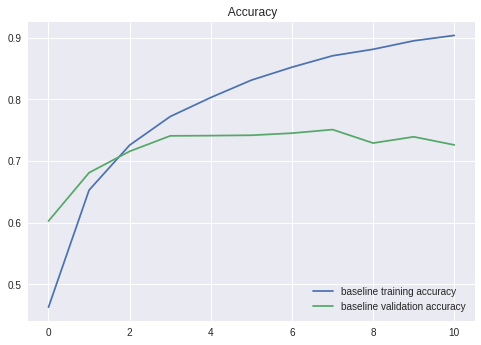

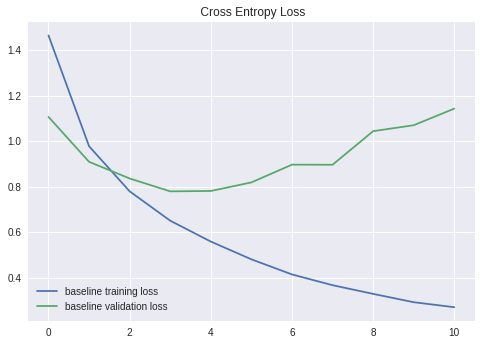

In [ ]:
plot_results(Histories)

 Conclusions for Baseline:

* We can see dramatic overfitting within the first 4 training epochs.
* The model was able to learn the training dataset, showing an improvement on the training dataset that at least continued to 12 epochs, and perhaps more. This is a good sign, as it shows that the problem is learnable and that the model have sufficient capacity to learn the problem.
* The results suggest that the model is in need of regularization to address the rapid overfitting of the test dataset. More generally, the results suggest that it may be useful to investigate techniques that slow down the convergence (rate of learning) of the model. This may include techniques such as data augmentation as well as learning rate schedules, changes to the batch size, and perhaps more.


1. We'll do Dropout 
2. We'll do weight Decay
3. We'll do Data Augmentation
4. We'll combine them to get better results
5. We'll do hyperparameter tuning


#### Hand Tuning 

 **Dropout**
 Parameters :
 * dropout_rate = 0.2

In [ ]:
Dropout_Model = fit_model(name="Dropout model",train_dataset=train_dataset,validation_dataset=validation_dataset,dropout=True,dropout_rate=0.2)
Histories["Dropout model"]=Dropout_Model

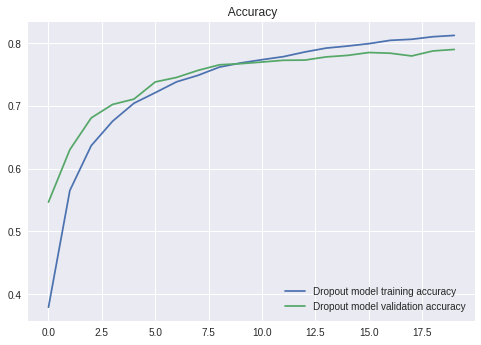

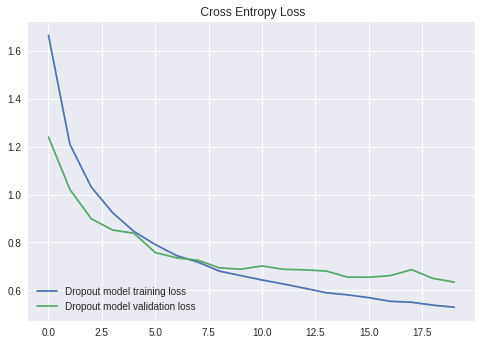

In [ ]:
plot_results(Histories)

 Conclusions after adding Dropout:

We achieved 79.03% peak accuracy with Dropout.
Eventhough it's overfitting we can give the model more epochs to get better results.
What may we try next? Weight Decay and Data Augmentation

**Weight Decay**
Parameters :
* l2 = 0.01

In [ ]:
WeightDecay_Model = fit_model(name="Weight decay model",train_dataset=train_dataset,validation_dataset=validation_dataset,regularizer=True,weight_decay=0.01,callbacks=False)
Histories["Weight decay model"]=WeightDecay_Model

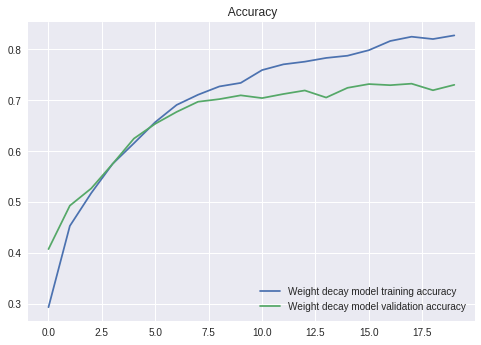

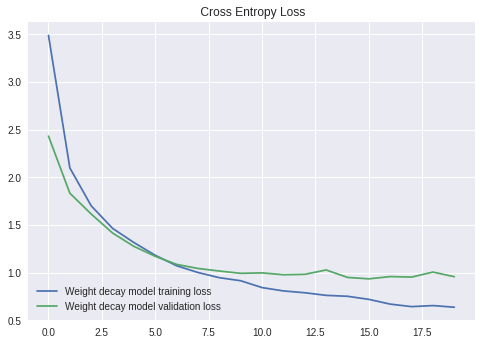

In [ ]:
plot_results(Histories)

As we can see our model is still overfitting the training data but it's performing slightly better than the baseline model.
Since We've done regularization only for dense layer we can add dropout to this model later on and spectaculate the results of the combined model.

**Data Augmentation**

In [ ]:
augmented_model = fit_model(name="Data augmentation model",train_dataset=train_aug_dataset,validation_dataset=validation_dataset,epochs=100)
Histories["Data augmentation model"]=augmented_model

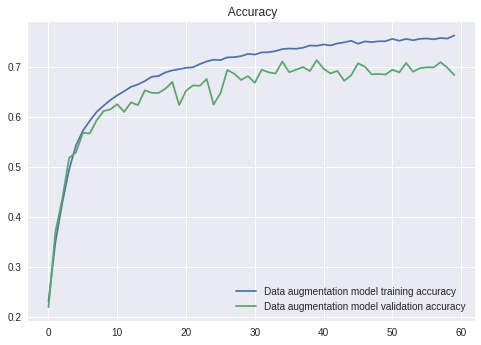

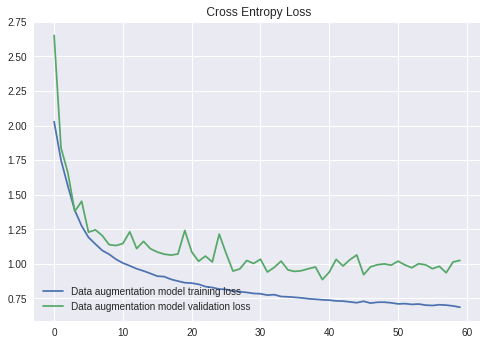

In [ ]:
plot_results(Histories)

The model is improving with augmented data since it hasn't rapidly overfit the data. We can combine this method later on with other regularization techniques

**Weight Decay + Dropout**

Parameters: 
* l2 = 0.01
* dropout_rate=0.2

In [ ]:
combined_model = fit_model(name="Combined model",train_dataset=train_dataset,validation_dataset=validation_dataset,dropout=True,dropout_rate=0.2,regularizer=True,weight_decay=0.01)
Histories["Combined model"]=combined_model

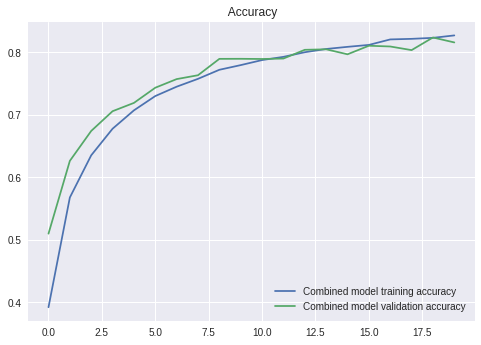

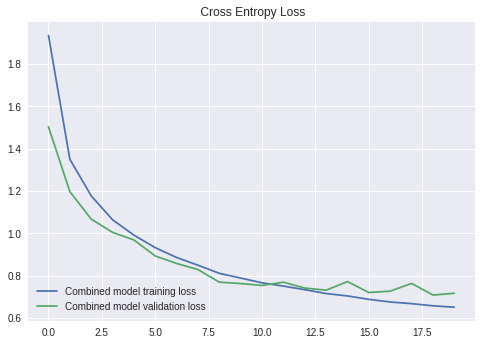

In [ ]:
plot_results(Histories)

The results Are quite impressive with both Dropout and L2 kernel regularization, We don't see overfitting phenomenon anymore.
Now it's time to give more epochs for the model to get better results on Validation set 

In [ ]:
combined_model = fit_model(name="Combined model 200 epochs",train_dataset=train_dataset,validation_dataset=validation_dataset,dropout=True,dropout_rate=0.2,regularizer=True,weight_decay=0.01,epochs=200)
Histories["Combined model 200 epochs"]=combined_model

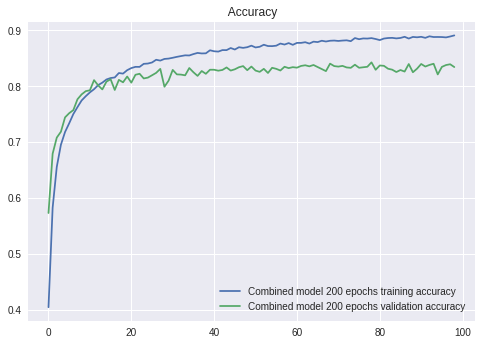

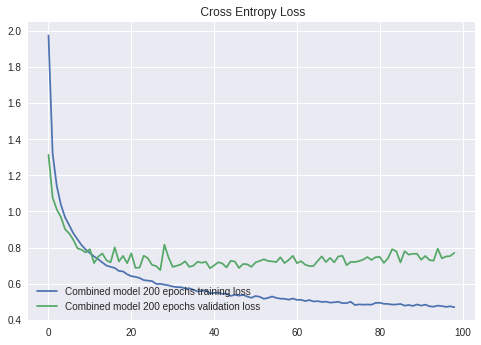

In [ ]:
plot_results(Histories)

Nice! We achieved 84% peak accuracy with this model eventhough it's still slightly overfitting! 
Let's go one step further and add Batch Normalization.

(We'll increase a little bit the weight decay to try avoid overfitting)

**Dropout + Weight Decay + Batch Normalization**

Parameters :
* Dropout_rate = 0.2
* l2 = 0.07

We increased the l2 weight decay value to reduce overfitting and added batch normalization to make the model converge faster and get better results earlier

In [ ]:
combined_model = fit_model(name="Combined model 200 epochs V2",train_dataset=train_dataset,validation_dataset=validation_dataset,dropout=True,dropout_rate=0.2,regularizer=True,weight_decay=0.07,batch_normalization=True,epochs=200)
Histories["Combined model 200 epochs V2"]=combined_model

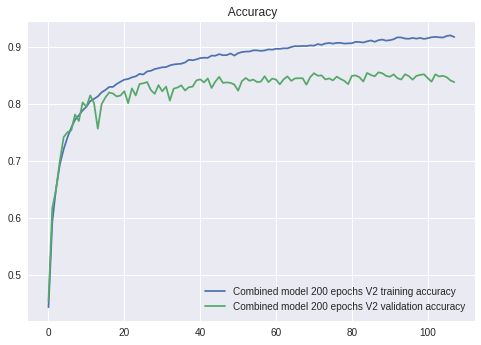

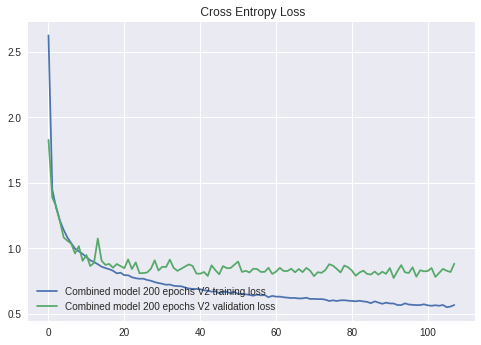

In [ ]:
plot_results(Histories)

Our model got 1.5% increase on the validation set and better overall accuracy on eralier epochs

**Weight Decay + Data Augmentation + Batch Normalization + Dropout**

Parameters :
* dropout_rate = 0.2
* l2 = 1e-2

In [ ]:
combined_model = fit_model(name="Combined model 200 epochs V3",train_dataset=train_aug_dataset,validation_dataset=validation_dataset,dropout=True,dropout_rate=0.2,regularizer=True,weight_decay=0.01,batch_normalization=True,epochs=200)
Histories["Combined model 200 epochs V3"]=combined_model

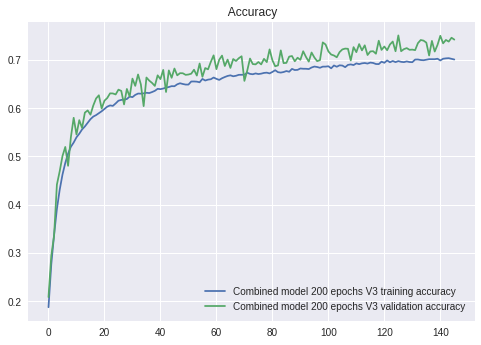

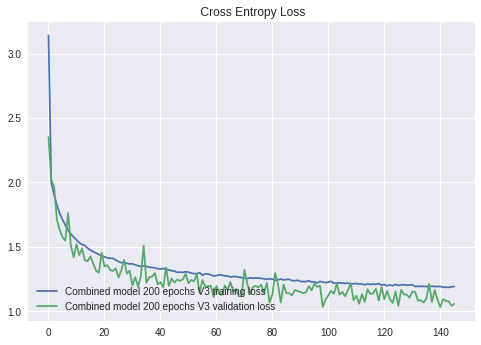

In [ ]:

plot_results(Histories)

Let's give it more epochs to converge.
For this we are going to use TPUs to get maximum execution speed 

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  final_model = fit_model(name="Final model",train_dataset=train_aug_dataset,validation_dataset=validation_dataset,dropout=True,dropout_rate=0.2,regularizer=True,weight_decay=0.01,batch_normalization=True,epochs=1000,callbacks=False)


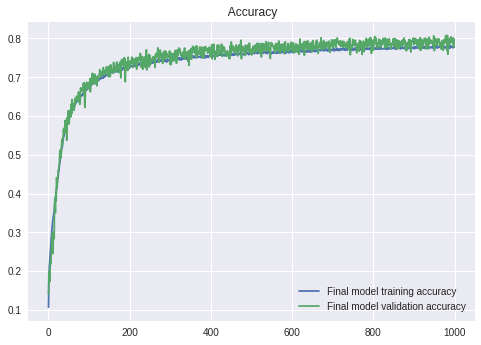

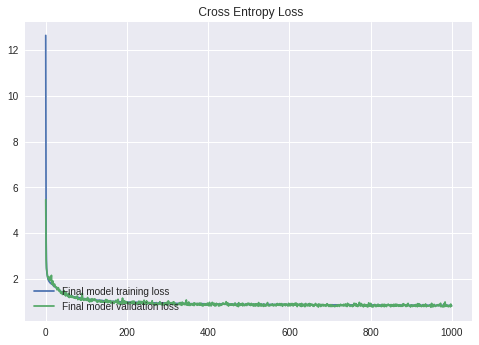

In [ ]:
Histories={}
Histories["Final model"]=final_model
plot_results(Histories)

Still we can do better ! let's decrease the weight decay further more 

Parameters: 
* Dropout_rate = 0.4
* weight_decay = 1e-3


In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  final_model = fit_model(name="Final model",train_dataset=train_aug_dataset,validation_dataset=validation_dataset,dropout=True,dropout_rate=0.4,regularizer=True,weight_decay=0.001,batch_normalization=True,epochs=1000,callbacks=False)

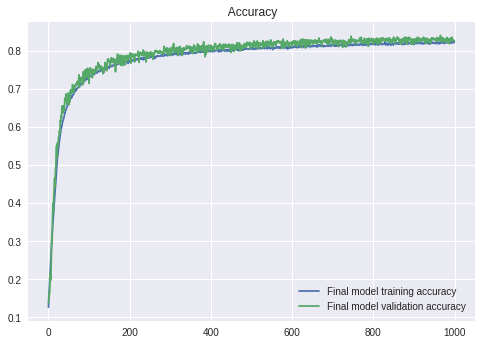

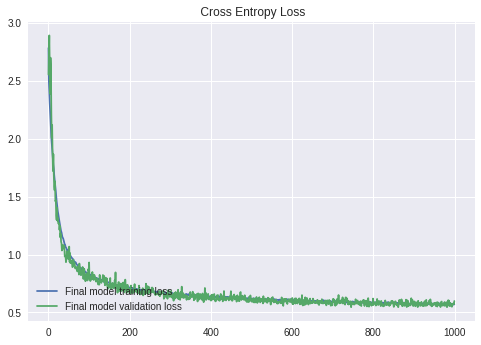

In [ ]:
Histories={}
Histories["Final model"]=final_model
plot_results(Histories)

We made it to 83% with the combined model! maybe it's time to do a RandomSearch on weight regularization Hyperparameter grid to get the best model 

#### RandomSearch Tuning 

In [ ]:
def model_builder(hp):
  hp_l2=hp.Choice("l2",values=[1e-6,1e-5,1e-4])
  model = tf.keras.Sequential()
  for i in range (3):
    model.add(tf.keras.layers.Conv2D(filters=32*(2**i),kernel_size=3,padding="same",activation="relu",kernel_initializer="he_uniform"))
    model.add(tf.keras.layers.Conv2D(filters=32*(2**i),kernel_size=3,padding="same",activation="relu",kernel_initializer="he_uniform"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(rate=0.4))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=128,activation="relu",kernel_initializer="he_uniform",kernel_regularizer=tf.keras.regularizers.l2(l=hp_l2)))
  model.add(tf.keras.layers.Dropout(rate=0.4))
  model.add(tf.keras.layers.Dense(units=10,activation="softmax",kernel_initializer="he_uniform",kernel_regularizer=tf.keras.regularizers.l2(l=hp_l2)))
  model.build(INPUT_SHAPE)
  model.summary()
  model.compile(optimizer="adam",loss=tf.keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])
  return model

In [ ]:
# TPUs won't work with Keras-Tuner since there is a problem in loading and saving a model from the TPU to localhost
# We'll be using GPUs
if tf.config.list_physical_devices('gpu'):
  strategy = tf.distribute.get_strategy() 

with strategy.scope():
  class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
      IPython.display.clear_output(wait = True)
  tuner = kt.RandomSearch(model_builder,
                      objective='val_accuracy',
                      max_trials=3,
                      executions_per_trial=1,
                      directory='/content/drive/My Drive/Cifar 10 /Cifar Tuner',
                      project_name='cifar 10')
  tuner.search_space_summary()
  tuner.search(train_aug_dataset,
              epochs=100,
              validation_data=validation_dataset,
              callbacks=[ClearTrainingOutput()])


In [ ]:
  models = tuner.get_best_models(num_models=1)
  best_model = models[0]
  best_model.save("/content/drive/My Drive/Cifar 10 /Tuned")
  

In [ ]:
tuned_model = tf.keras.models.load_model("/content/drive/My Drive/Cifar 10 /Tuned")
tuned =  tuned_model.fit(train_aug_dataset,
                          batch_size=BATCH_SIZE,
                          epochs=500,
                          validation_data=validation_dataset)
Histories["Tuned model"]=final

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  tuned = fit_model(name="Tuned model",train_dataset=train_aug_dataset,validation_dataset=validation_dataset,dropout=True,dropout_rate=0.4,regularizer=True,weight_decay=1e-6,batch_normalization=True,epochs=500,initial_epoch=tuned.epoch[-1],callbacks=False)

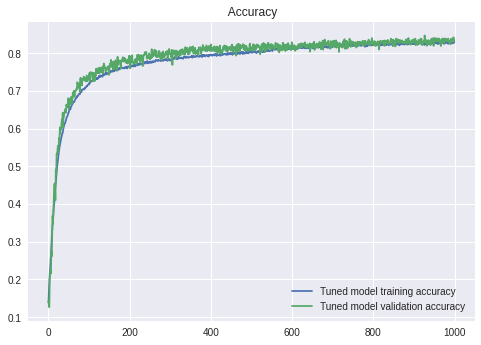

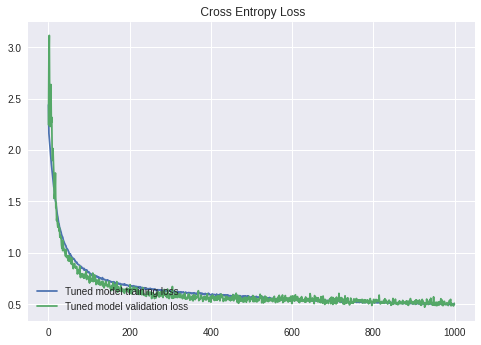

In [ ]:
Histories = {"Tuned model":tuned}
plot_results(Histories)

The Tuned model achieved 84.8 % accuracy which is better than the previous combined model. 

The best model is Combined model 200 epochs V2 with peak accuracy of 85.5%
So we're gonna use it to make predictions

We come to the end of this model building section as we run out from time resources.

How to improve this Model :
* Increase the number of epochs (e.g 2k or 4k) 
* Further tune the HyperParameters and try different combinations

### Evaluate the Model 

In [ ]:
def plot_conf(actual,prediction,class_names):
 
  true_label = np.argmax(actual)
  pred_label = np.argmax(prediction)
  plot = plt.bar(range(10), prediction, color="blue")
  plt.grid(False)
  plt.xticks(range(10),class_names,rotation=60)
  plt.yticks([])
  plt.ylim([0, 1])
  if true_label == pred_label:
    plot[pred_label].set_color("green")
  else :
    plot[pred_label].set_color("red")

In [ ]:
def plot_image(image,actual,prediction,class_names):
  true_label = np.argmax(actual)
  pred_label = np.argmax(prediction)
  plt.imshow(image)
  if true_label == pred_label : 
    color= "green"
  else:
    color = "red"
  plt.title(class_names[true_label],color=color)
  plt.grid(False)

In [ ]:
def plot_pred_conf(images,actuals,predictions,class_names):
  """
  Function that plots the evaluation images with their model predictions in a bar plot representing 
  the confidence of the model.
  args:
  * images: array-like,array of images
  * actuals: array-like,array of ground truth output values
  * predictions: array-like,array of predicted output values
  * class_names: list, list containing the class names 
   """
  plt.figure(figsize=(10,10))
  plt.style.use("seaborn")
  for i in range (10):
    plt.subplot(5,4,2*i+1)
    plot_image(images[i],actuals[i],predictions[i],class_names)
    plt.subplot(5,4,2*i+2)
    plot_conf(actuals[i],predictions[i],class_names)
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_confusion_matrix(predictions,actuals,class_names):
  """
  Plots the confusion matrix given the predictions of the model
  args:
  * actuals: array-like,array of ground truth output values
  * predictions: array-like,array of predicted output values
  * class_names: list, list containing the class names 
  """
  plt.figure(figsize=(11,11))
  matrix = metrics.confusion_matrix(predictions.argmax(axis=1),actuals.argmax(axis=1))
  sns.heatmap(matrix,xticklabels=class_names, yticklabels=class_names,annot=True)
  plt.show()

In [ ]:
def unbatchify(dataset):
  images =[]
  labels=[]
  for image , label in dataset.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(label)
  return  np.array(images) , np.array(labels)

In [ ]:
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
images, actuals = unbatchify(validation_dataset)
predictions = combined_model.predict(images)

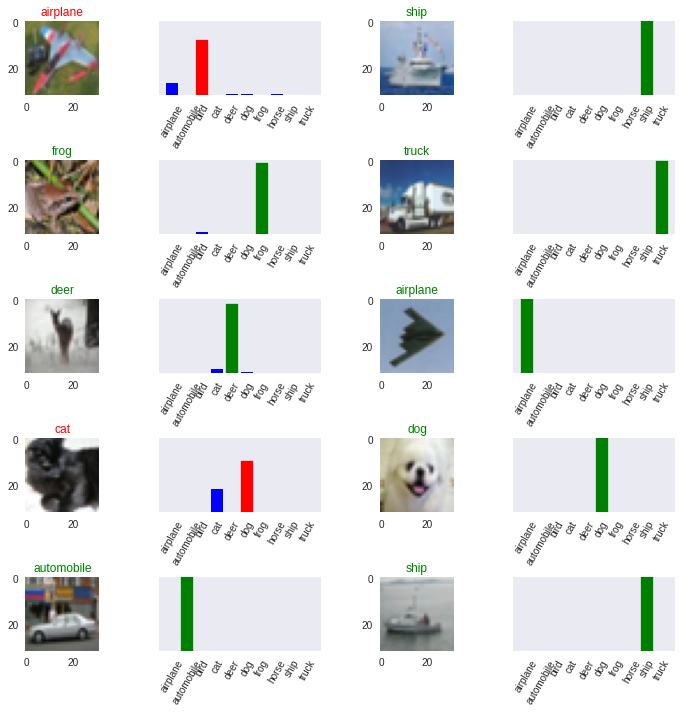

In [ ]:
plot_pred_conf(images,actuals,predictions,class_names)

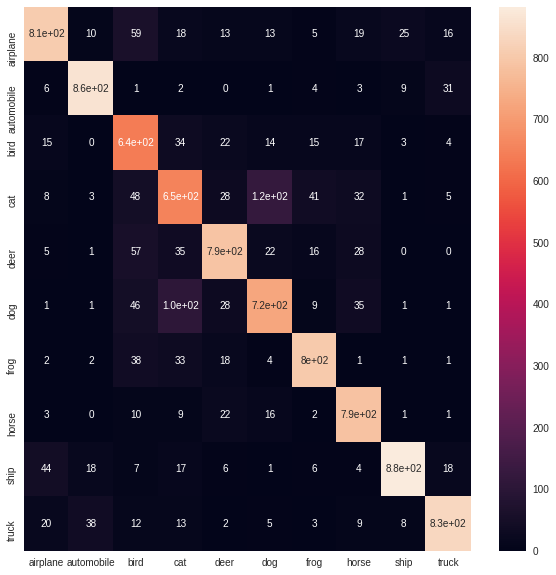

In [ ]:
plot_confusion_matrix(predictions,actuals,class_names)

As we can see The model has encountred problems differentiating between Cats and dogs. Also, it found some problems recognizing the birds. This makes clearer why we didn't achieve higher accuracy values (90%+) in this problem. 